In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.01 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 36790 
    Total predicted counts          : 37111.54
    Total off counts                : 102012.00

    Total background counts         : 20402.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 1000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 5.36 s, sys: 31.9 ms, total: 5.39 s
Wall time: 5.4 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 37031 
    Total predicted counts          : 37041.14
    Total off counts                : 101660.00

    Total background counts         : 20332.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 36776 
    Total predicted counts          : 36975.54
    Total off counts                : 101332.00

    Total background counts         : 2

SpectrumDatasetOnOff

    Name                            : obs_25 

    Total counts                    : 36985 
    Total predicted counts          : 37014.14
    Total off counts                : 101525.00

    Total background counts         : 20305.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_26 

    Total counts                    : 37183 
    Total predicted counts          : 37037.14
    Total off counts                : 101640.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_55 

    Total counts                    : 37124 
    Total predicted counts          : 37071.34
    Total off counts                : 101811.00

    Total background counts         : 20362.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_56 

    Total counts                    : 36962 
    Total predicted counts          : 37000.74
    Total off counts                : 101458.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_80 

    Total counts                    : 37032 
    Total predicted counts          : 36888.14
    Total off counts                : 100895.00

    Total background counts         : 20179.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_81 

    Total counts                    : 37217 
    Total predicted counts          : 36908.54
    Total off counts                : 100997.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_115 

    Total counts                    : 37201 
    Total predicted counts          : 36907.74
    Total off counts                : 100993.00

    Total background counts         : 20198.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_116 

    Total counts                    : 36804 
    Total predicted counts          : 36993.94
    Total off counts                : 101424.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_145 

    Total counts                    : 36913 
    Total predicted counts          : 36970.14
    Total off counts                : 101305.00

    Total background counts         : 20261.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_146 

    Total counts                    : 37201 
    Total predicted counts          : 37016.34
    Total off counts                : 101536.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_179 

    Total counts                    : 36964 
    Total predicted counts          : 36964.14
    Total off counts                : 101275.00

    Total background counts         : 20255.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_180 

    Total counts                    : 37056 
    Total predicted counts          : 37061.74
    Total off counts                : 101763.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_213 

    Total counts                    : 36971 
    Total predicted counts          : 36939.34
    Total off counts                : 101151.00

    Total background counts         : 20230.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_214 

    Total counts                    : 36696 
    Total predicted counts          : 36981.74
    Total off counts                : 101363.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_245 

    Total counts                    : 37371 
    Total predicted counts          : 37080.94
    Total off counts                : 101859.00

    Total background counts         : 20371.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_246 

    Total counts                    : 36875 
    Total predicted counts          : 36982.34
    Total off counts                : 101366.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_275 

    Total counts                    : 36731 
    Total predicted counts          : 37048.74
    Total off counts                : 101698.00

    Total background counts         : 20339.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_276 

    Total counts                    : 37078 
    Total predicted counts          : 37058.34
    Total off counts                : 101746.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_302 

    Total counts                    : 36849 
    Total predicted counts          : 36941.34
    Total off counts                : 101161.00

    Total background counts         : 20232.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_303 

    Total counts                    : 36960 
    Total predicted counts          : 37085.14
    Total off counts                : 101880.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_322 

    Total counts                    : 37031 
    Total predicted counts          : 36937.74
    Total off counts                : 101143.00

    Total background counts         : 20228.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_323 

    Total counts                    : 37125 
    Total predicted counts          : 36975.94
    Total off counts                : 101334.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_347 

    Total counts                    : 37015 
    Total predicted counts          : 36915.14
    Total off counts                : 101030.00

    Total background counts         : 20206.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_348 

    Total counts                    : 36703 
    Total predicted counts          : 37037.34
    Total off counts                : 101641.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_376 

    Total counts                    : 37492 
    Total predicted counts          : 37081.54
    Total off counts                : 101862.00

    Total background counts         : 20372.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_377 

    Total counts                    : 36833 
    Total predicted counts          : 37111.54
    Total off counts                : 102012.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_409 

    Total counts                    : 36974 
    Total predicted counts          : 36990.74
    Total off counts                : 101408.00

    Total background counts         : 20281.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_410 

    Total counts                    : 36885 
    Total predicted counts          : 36977.54
    Total off counts                : 101342.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_443 

    Total counts                    : 37084 
    Total predicted counts          : 36918.34
    Total off counts                : 101046.00

    Total background counts         : 20209.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_444 

    Total counts                    : 37030 
    Total predicted counts          : 36916.94
    Total off counts                : 101039.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_475 

    Total counts                    : 36799 
    Total predicted counts          : 37074.54
    Total off counts                : 101827.00

    Total background counts         : 20365.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_476 

    Total counts                    : 36873 
    Total predicted counts          : 37025.54
    Total off counts                : 101582.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_508 

    Total counts                    : 37029 
    Total predicted counts          : 37023.74
    Total off counts                : 101573.00

    Total background counts         : 20314.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_509 

    Total counts                    : 36906 
    Total predicted counts          : 37031.34
    Total off counts                : 101611.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_540 

    Total counts                    : 37072 
    Total predicted counts          : 37063.14
    Total off counts                : 101770.00

    Total background counts         : 20354.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_541 

    Total counts                    : 36663 
    Total predicted counts          : 36942.14
    Total off counts                : 101165.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_568 

    Total counts                    : 37056 
    Total predicted counts          : 36967.14
    Total off counts                : 101290.00

    Total background counts         : 20258.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_569 

    Total counts                    : 37314 
    Total predicted counts          : 37013.74
    Total off counts                : 101523.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_602 

    Total counts                    : 37228 
    Total predicted counts          : 37013.34
    Total off counts                : 101521.00

    Total background counts         : 20304.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_603 

    Total counts                    : 36863 
    Total predicted counts          : 36979.54
    Total off counts                : 101352.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_634 

    Total counts                    : 36992 
    Total predicted counts          : 37079.74
    Total off counts                : 101853.00

    Total background counts         : 20370.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_635 

    Total counts                    : 37186 
    Total predicted counts          : 37005.54
    Total off counts                : 101482.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_667 

    Total counts                    : 37183 
    Total predicted counts          : 37063.74
    Total off counts                : 101773.00

    Total background counts         : 20354.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_668 

    Total counts                    : 36948 
    Total predicted counts          : 37092.14
    Total off counts                : 101915.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_701 

    Total counts                    : 37257 
    Total predicted counts          : 36983.54
    Total off counts                : 101372.00

    Total background counts         : 20274.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_702 

    Total counts                    : 36947 
    Total predicted counts          : 37008.14
    Total off counts                : 101495.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_731 

    Total counts                    : 36956 
    Total predicted counts          : 37004.94
    Total off counts                : 101479.00

    Total background counts         : 20295.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_732 

    Total counts                    : 37346 
    Total predicted counts          : 36919.14
    Total off counts                : 101050.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_764 

    Total counts                    : 37374 
    Total predicted counts          : 36953.74
    Total off counts                : 101223.00

    Total background counts         : 20244.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_765 

    Total counts                    : 36869 
    Total predicted counts          : 36994.54
    Total off counts                : 101427.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_797 

    Total counts                    : 36905 
    Total predicted counts          : 37061.74
    Total off counts                : 101763.00

    Total background counts         : 20352.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_798 

    Total counts                    : 37141 
    Total predicted counts          : 37092.94
    Total off counts                : 101919.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_830 

    Total counts                    : 37144 
    Total predicted counts          : 37078.74
    Total off counts                : 101848.00

    Total background counts         : 20369.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_831 

    Total counts                    : 37096 
    Total predicted counts          : 36931.14
    Total off counts                : 101110.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_863 

    Total counts                    : 37255 
    Total predicted counts          : 37116.74
    Total off counts                : 102038.00

    Total background counts         : 20407.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_864 

    Total counts                    : 36785 
    Total predicted counts          : 37072.54
    Total off counts                : 101817.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_894 

    Total counts                    : 36774 
    Total predicted counts          : 37033.34
    Total off counts                : 101621.00

    Total background counts         : 20324.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_895 

    Total counts                    : 37182 
    Total predicted counts          : 36944.94
    Total off counts                : 101179.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_928 

    Total counts                    : 37028 
    Total predicted counts          : 37009.74
    Total off counts                : 101503.00

    Total background counts         : 20300.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_929 

    Total counts                    : 37024 
    Total predicted counts          : 37081.14
    Total off counts                : 101860.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_963 

    Total counts                    : 36988 
    Total predicted counts          : 36961.14
    Total off counts                : 101260.00

    Total background counts         : 20252.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_964 

    Total counts                    : 37167 
    Total predicted counts          : 36947.74
    Total off counts                : 101193.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_997 

    Total counts                    : 36857 
    Total predicted counts          : 36941.34
    Total off counts                : 101161.00

    Total background counts         : 20232.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_998 

    Total counts                    : 36959 
    Total predicted counts          : 37030.34
    Total off counts                : 101606.00

    Total background counts         

Text(0, 0.5, 'No. of observations')

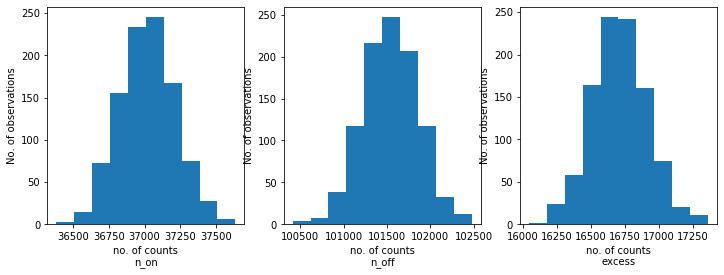

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 3min 26s, sys: 677 ms, total: 3min 26s
Wall time: 3min 33s


In [15]:
results

[{'index': 2.203480656028608,
  'amplitude': 1.319131223495981e-12,
  'lambda_': 0.013352732699866327},
 {'index': 2.216551178307587,
  'amplitude': 1.2725453446582055e-12,
  'lambda_': 0.012480063961532253},
 {'index': 2.2335639880896676,
  'amplitude': 1.2564924970102983e-12,
  'lambda_': 0.0072483906282169285},
 {'index': 2.2237083872295806,
  'amplitude': 1.2773920002908233e-12,
  'lambda_': 0.010494121103543178},
 {'index': 2.23559148008517,
  'amplitude': 1.2791173736763305e-12,
  'lambda_': 0.007843659678971531},
 {'index': 2.218221845526143,
  'amplitude': 1.2812586132237533e-12,
  'lambda_': 0.009791377910732025},
 {'index': 2.226136664494706,
  'amplitude': 1.2713707997318236e-12,
  'lambda_': 0.005722998180854309},
 {'index': 2.2226220144232536,
  'amplitude': 1.275810972118856e-12,
  'lambda_': 0.008042198413201269},
 {'index': 2.2014059217857174,
  'amplitude': 1.3207168628601819e-12,
  'lambda_': 0.016130245144718953},
 {'index': 2.21359023766153,
  'amplitude': 1.2931702

index: 2.220193921545787 += 0.008904217944712944


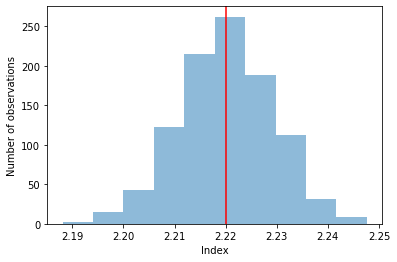

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.2888001977871752e-12 += 1.8528743940432024e-14


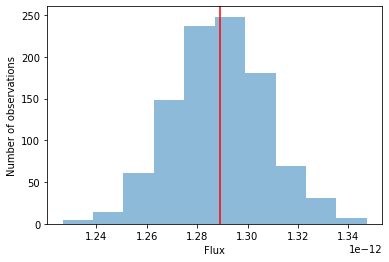

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 0.010071288361913924 += 0.0026380925210984937


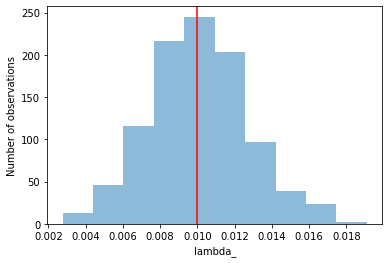

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")